# Utility Functions
Date: 2022-02-21  
Author: Matt McDonnell @mattmcd

Looking at 'Quantitative Financial Economics' by Cuthbertson and Nitzsche to understand utility functions and
indifference curves.

In [1]:
import sympy as sp
from sympy.interactive import printing
printing.init_printing(use_latex=True)

In [2]:
from sympy.stats import Bernoulli, LogNormal, density, sample, P as Prob, E as Expected, variance

Start by looking at a fair lottery random.  A Bernoulli distribution can be used to represent a fair lottery
with proability $p$ for payoff $k_1$, probability $1-p$ for payoff of $k_2$.  If the lottery is fair it has 
expected value of zero, which can be used to solve for $p$.

In [3]:
k1, k2 = sp.symbols('k1 k2', real=True)
p = sp.symbols('p', nonnegative=True)
Xs = sp.symbols('X')

In [4]:
X = Bernoulli('X', p=p, succ=k1, fail=k2)

In [5]:
Expected(X)

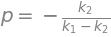

In [6]:
sp.Eq(p, sp.solve(Expected(X), p)[0])

Playing around with random variables

In [7]:
# Doesn't work - same RV?
# FairCoin = X.subs({p: sp.S.Half, k1: 1, k2: -1})
# FairCoin2 = X.subs({p: sp.S.Half, k1: -1, k2: 1})

# Works
FairCoin = Bernoulli('X1', p=sp.S.Half, succ=1, fail=-1)
FairCoin2 = Bernoulli('X2', p=sp.S.Half, succ=1, fail=-1)

In [8]:
sample(FairCoin + FairCoin2, size=(10,))

array([ 2,  2,  0,  2,  0, -2,  0,  0,  0,  0])

In [9]:
Prob(X.subs({p: 1/2, k1:1, k2:-1}) > 0)

## Worked example and definition of Utility 
Below we follow the example from p14-17, of a bet on a fair coin flip, $p=1/2$,
that costs \\$10 to enter, and pays off \\$16 for a win, \\$4 for a loss.

In [10]:
# Expected value of FairCoin toss with payoff $16 and $4. 
# No risk aversion -> would pay up to this amount for the bet
Payoff = X.subs({p: sp.S.Half, k1: 16, k2: 4})
Expected(Payoff)

Now consider a utility function of the form $U(W) = \sqrt{W}$, where $W$ is the wealth of the player.

In [11]:
# Expected utility of the FairCoin toss with payoff $16 and $4 for sqrt utility
# i.e. U(W) = sqrt(W)
d = sp.Dummy()
U = sp.Lambda(d, sp.sqrt(d))
Expected(U(Payoff))

We see that the expected utility of the bet is less than the utility of the original \\$10:

In [12]:
# Utility of keeping $10 rather than paying $10 for bet
U(10).evalf()

Calculate the risk premium: what would you pay not to have to take the bet?

In [13]:
# Calculate the risk premium: what would you pay not to have to take the bet?
initial_wealth = 10
bet_cost = 10
sp.solve(U(initial_wealth-d) - Expected(U(initial_wealth + Payoff - bet_cost)), d)[0].evalf()

We can go back to the general form for the lottery and calculate the risk premium $\pi$ as a function of the other
parameters, assuming that the cost to enter the bet is given by the fair value of the lottery.

(Sidenote: I'm not a fan of using $\pi$ to represent risk premium, seems like it's asking for trouble if $\pi$
the number crops up in expressions.)

In [14]:
# General form
W, c, pis = sp.symbols('W, c, pi', real=True)
# Solve for cost
sp.Eq(c, sp.solve(Expected(X - c), c)[0].collect([k1, k2]))

In [15]:
sp.Eq(pis, sp.solve(U(W-pis) - Expected(U(W + X - Expected(X))), pis)[0].simplify().collect(p))

Relate risk premium to utility function curvature.  
Assume general RV for (payoff - cost), assume this has $E[x] == 0$ i.e. cost is expected payoff.  
This also means var(x) = $E[x^2]$.

In [16]:
x = sp.stats.rv.RandomSymbol('x')   
Us = sp.symbols('U', cls=sp.Function)
sp.Eq(Us(W - pis), Expected(Us(W + x)))

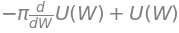

In [17]:
lhs = sp.series(Us(W - pis), pis, n=2).removeO().simplify()
lhs

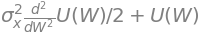

In [18]:
sigma_sq_x = sp.symbols('sigma_x^2', positive=True)
rhs = Expected(
    sp.series(Us(W + x), x, n=3).removeO()
).collect(Us(W)).subs(Expected(x), 0).subs({Expected(x**2): sigma_sq_x})
rhs

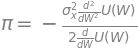

In [19]:
pi = sp.solve(lhs - rhs, pis)[0]
sp.Eq(pis, pi)

We get to the form for risk premium given in the text, using SymPy to do the required manipulations.

# Risk Aversion Coefficients
We can extract the term containing $U(W)$ into the coefficient for absolute risk aversion $R_A$ and from this the 
coefficient for relative risk aversion $R_R$

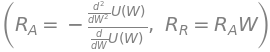

In [20]:
Ras, Rrs = sp.symbols('R_A R_R', positive=True)
Ra = pi/(sigma_sq_x/2)
Rr = W*Ras
Rau = lambda U: Ra.subs(Us(W), U).simplify().powsimp()
sp.Eq(Ras, Ra), sp.Eq(Rrs, Rr)

Then we can apply these definitions to some utility functions of interest: constant relative risk aversion, 
constant absolute risk aversion, quadratic 

In [21]:
g, a, b, c = sp.symbols('gamma a b c', positive=True)
U_crras, U_caras, U_qs = sp.symbols('U_{CRRA} U_{CARA} U_Q', cls=sp.Function)
U_crra = W**(1-g)/(1-g)
U_cara = a - b*sp.exp(-c*W)
U_q = W - b/2*W**2

### Constant Relative Risk Aversion

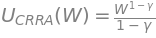

In [22]:
sp.Eq(U_crras(W), U_crra)

In [23]:
sp.Eq(Ras, Rau(U_crra)), sp.Eq(Rrs, Rr.subs(Ras, Rau(U_crra)))

### Constant Absolute Risk Aversion

In [24]:
sp.Eq(U_caras(W), U_cara)

In [25]:
sp.Eq(Ras, Rau(U_cara)), sp.Eq(Rrs, Rr.subs(Ras, Rau(U_cara)))

### Quadratic Utility

In [26]:
sp.Eq(U_qs(W), U_q)

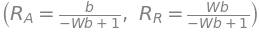

In [27]:
sp.Eq(Ras, Rau(U_q)), sp.Eq(Rrs, Rr.subs(Ras, Rau(U_q)))